Step 1: Loading training and test data...
Training data shape: (891, 12)
Test data shape: (418, 11)

First 3 rows of training 
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  

First 3 rows of test 
   PassengerId  Pclass                              Name     Sex   Age  SibSp  \
0          892       3                  Kelly, Mr. James    male  34.5      0   
1          893       3

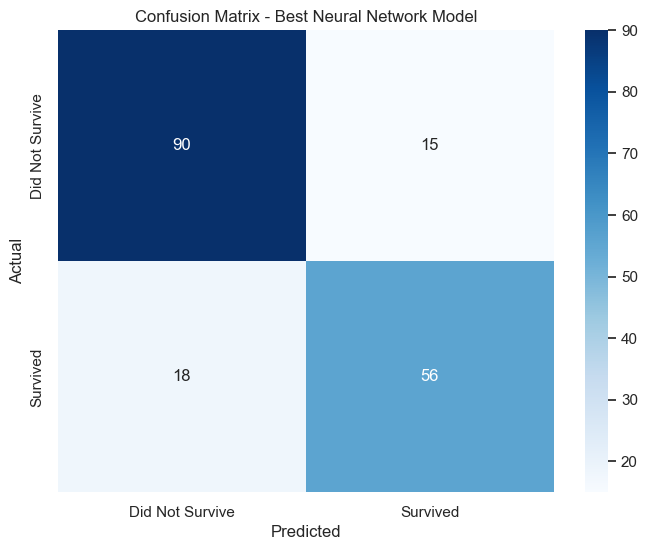


Step 7: Training final model on full training data and making test predictions...

Final submission file created: neural_network_submission.csv
Shape of submission: (418, 2)
First 10 predictions:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0

Final model saved as 'final_neural_network_model.pkl'

Neural Network model training and prediction complete!
The 'neural_network_submission.csv' file is ready for submission.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier

# Set style for plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# --- Step 1: Load the Training and Test Data ---
print("Step 1: Loading training and test data...")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Save passenger IDs for the final submission
test_passenger_ids = test['PassengerId'].copy()

# Display basic information
print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"\nFirst 3 rows of training ")
print(train.head(3))
print(f"\nFirst 3 rows of test ")
print(test.head(3))
print(f"\nMissing values in training data:")
print(train.isnull().sum())
print(f"\nMissing values in test data:")
print(test.isnull().sum())

# --- Step 2: Data Preprocessing and Feature Engineering ---
print("\nStep 2: Preprocessing and feature engineering...")

def preprocess_data(df):
    # Feature engineering
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    title_mapping = {
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
        'Lady': 'Royalty', 'Countess': 'Royalty', 'Dona': 'Royalty',
        'Sir': 'Royalty', 'Jonkheer': 'Royalty',
        'Don': 'Royalty', 'Dr': 'Officer', 'Rev': 'Officer',
        'Major': 'Officer', 'Col': 'Officer', 'Capt': 'Officer'
    }
    df['Title'] = df['Title'].replace(title_mapping)
    
    # Create family size features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # Create age groups
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], 
                           labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])
    
    # Create fare groups
    df['FareGroup'] = pd.qcut(df['Fare'], 4, labels=['Low', 'Medium', 'High', 'Very High'])
    
    # Cabin availability indicator
    df['HasCabin'] = df['Cabin'].notnull().astype(int)
    
    # Drop columns for modeling
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    
    return df

# Preprocess both training and test sets
X_train_full = preprocess_data(train.copy())
X_test = preprocess_data(test.copy())

# Define target variable for training set
y_train_full = X_train_full['Survived']
X_train_full = X_train_full.drop('Survived', axis=1) # Remove target from features

# Identify feature types after preprocessing
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup', 'HasCabin']

print(f"Features after preprocessing: {list(X_train_full.columns)}")

# --- Step 3: Split Training Data for Validation ---
print("\nStep 3: Splitting training data for validation...")
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# --- Step 4: Create Preprocessing Pipeline ---
print("\nStep 4: Setting up preprocessing pipeline...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()) # StandardScaler is important for Neural Networks
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_features)
    ])

# --- Step 5: Train the Neural Network Model with Hyperparameter Tuning ---
print("\nStep 5: Training and tuning the Neural Network model...")

# Define the model pipeline
# MLPClassifier is sklearn's Multi-layer Perceptron (Neural Network)
nn_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(random_state=42, max_iter=1000))
])

# Define the parameter grid for hyperparameter tuning
# Neural networks have many hyperparameters, we'll focus on a few key ones
param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], # Architecture: (neurons_in_layer1, neurons_in_layer2, ...)
    'classifier__alpha': [0.0001, 0.001, 0.01],                           # L2 regularization strength
    'classifier__learning_rate_init': [0.001, 0.01]                        # Initial learning rate
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=nn_model,
    param_grid=param_grid,
    cv=3,                    # Number of cross-validation folds (reduced for speed)
    scoring='accuracy',
    n_jobs=-1,               # Use all available processors
    verbose=1                # Print progress
)

# Fit the GridSearchCV (this trains many models with different parameters)
grid_search.fit(X_train, y_train)

# Get the best model
best_nn_model = grid_search.best_estimator_
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# --- Step 6: Evaluate the Best Model on Validation Set ---
print("\nStep 6: Evaluating the best model on the validation set...")

# Make predictions on the validation set
y_pred = best_nn_model.predict(X_val)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Print a detailed classification report
print(f"\nClassification Report:")
print(classification_report(y_val, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Did Not Survive', 'Survived'],
           yticklabels=['Did Not Survive', 'Survived'])
plt.title('Confusion Matrix - Best Neural Network Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Step 7: Train Final Model on Full Training Data and Make Test Predictions ---
print("\nStep 7: Training final model on full training data and making test predictions...")

# Train the best model configuration on the *entire* training dataset
# This is the final model used for the competition submission
final_model = grid_search.best_estimator_
final_model.fit(X_train_full, y_train_full) # Use the full training data

# Make predictions on the test set
test_predictions = final_model.predict(X_test)

# Create the final submission file
submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': test_predictions
})

# Save the submission file
submission.to_csv('neural_network_submission.csv', index=False)
print(f"\nFinal submission file created: neural_network_submission.csv")
print(f"Shape of submission: {submission.shape}")
print(f"First 10 predictions:")
print(submission.head(10))

# --- Step 8: Save the Final Trained Model ---
import joblib
joblib.dump(final_model, 'final_neural_network_model.pkl')
print("\nFinal model saved as 'final_neural_network_model.pkl'")

print("\nNeural Network model training and prediction complete!")
print("The 'neural_network_submission.csv' file is ready for submission.")